In [1]:
import pandas as pd
import dask.dataframe as dd
import dask
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error
from glob import glob
import os
import gc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import tqdm

gc.collect()

0

In [2]:
train_path = '/home/stargix/Desktop/hackathons/datathon/train/train'
test_path = '/home/stargix/Desktop/hackathons/datathon/test/test'


BASELINE = 0.160384

In [3]:
# Definir columnas necesarias
required_columns = [
    'row_id', 'datetime',
    'buyer_d7', 'iap_revenue_d7',
    'advertiser_bundle', 'advertiser_category', 'advertiser_subcategory', 
    'advertiser_bottom_taxonomy_level',
    'country', 'region',
    'dev_make', 'dev_model', 'dev_os', 'dev_osv',
    'carrier',
    'hour', 'weekday', 'weekend_ratio', 'hour_ratio',
    'release_date', 'release_msrp',
    'avg_act_days', 'avg_daily_sessions', 'avg_days_ins', 'avg_duration',
    'weeks_since_first_seen', 'wifi_ratio',
    'retentiond7',
    'city_hist', 'country_hist', 'region_hist', 'dev_language_hist', 'dev_osv_hist',
    'cpm', 'cpm_pct_rk', 'ctr', 'ctr_pct_rk',
    'iap_revenue_usd_bundle', 'iap_revenue_usd_category',
    'num_buys_bundle', 'num_buys_category',
    'last_buy', 'last_ins',
    'bcat', 'bcat_bottom_taxonomy',
    'bundles_cat', 'bundles_cat_bottom_taxonomy', 
    'bundles_ins',
    'new_bundles', 'user_bundles', 'user_bundles_l28d',
    'advertiser_actions_action_count', 'advertiser_actions_action_last_timestamp',
    'user_actions_bundles_action_count', 'user_actions_bundles_action_last_timestamp',
    'last_advertiser_action',
    'first_request_ts', 'first_request_ts_bundle', 
    'first_request_ts_category_bottom_taxonomy',
    'rwd_prank',
    'whale_users_bundle_num_buys_prank', 'whale_users_bundle_revenue_prank'
]

# Cargar datos (10% de los archivos)
parquet_files_train = glob(os.path.join(train_path, '**/part-*.parquet'), recursive=True)
num_files_train = max(1, int(len(parquet_files_train) * 0.1))
parquet_files_train = parquet_files_train[:num_files_train]

try:
    train_ddf = dd.read_parquet(parquet_files_train, engine='pyarrow', columns=required_columns)
    print(f"✓ Train cargado con {num_files_train} archivos")
except Exception as e:
    print(f"⚠️ Cargando todas las columnas: {e}")
    train_ddf = dd.read_parquet(parquet_files_train, engine='pyarrow')

# Computar a Pandas
train_df = train_ddf.compute(scheduler='synchronous')
print(f"✓ Train shape: {train_df.shape}")

✓ Train cargado con 14 archivos
✓ Train shape: (2104266, 62)
✓ Train shape: (2104266, 62)


In [4]:
# Preprocesar columnas con listas - SUMAR todos los valores
import ast

columns_to_sum = [
    'iap_revenue_usd_bundle',
    'num_buys_bundle',
    'rwd_prank',
    'whale_users_bundle_num_buys_prank',
    'whale_users_bundle_revenue_prank'
]

print("=" * 60)
print("PREPROCESANDO COLUMNAS CON LISTAS")
print("=" * 60)

def sum_values(x):
    """Suma todos los valores numéricos de la lista"""
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return 0
    try:
        # Si es string, convertir a lista
        if isinstance(x, str):
            x = ast.literal_eval(x)
        
        # Si es lista de tuplas, sumar el segundo valor de cada tupla
        if isinstance(x, list) and len(x) > 0:
            total = sum([item[1] for item in x if isinstance(item, tuple) and len(item) > 1])
            return total
        return 0
    except:
        return 0

for col in columns_to_sum:
    if col in train_df.columns:
        print(f"\n📊 Procesando {col}...")
        
        # Aplicar transformación
        train_df[col] = train_df[col].apply(sum_values)
        
        # Verificar resultado
        print(f"  ✓ Convertido a numérico")
        print(f"  Tipo nuevo: {train_df[col].dtype}")
        print(f"  Valores ejemplo: {train_df[col].head(3).values}")
        print(f"  Stats: min={train_df[col].min():.4f}, max={train_df[col].max():.4f}, mean={train_df[col].mean():.4f}")
    else:
        print(f"\n❌ {col} - NO ENCONTRADA")

print("\n" + "=" * 60)
print("✓ PREPROCESAMIENTO COMPLETADO")
print("=" * 60)

PREPROCESANDO COLUMNAS CON LISTAS

📊 Procesando iap_revenue_usd_bundle...
  ✓ Convertido a numérico
  Tipo nuevo: float64
  Valores ejemplo: [0. 0. 0.]
  Stats: min=0.0000, max=744884.6500, mean=4.4307

📊 Procesando num_buys_bundle...
  ✓ Convertido a numérico
  Tipo nuevo: float64
  Valores ejemplo: [0. 0. 0.]
  Stats: min=0.0000, max=744884.6500, mean=4.4307

📊 Procesando num_buys_bundle...
  ✓ Convertido a numérico
  Tipo nuevo: int64
  Valores ejemplo: [0 0 0]
  Stats: min=0.0000, max=4127.0000, mean=0.5360

📊 Procesando rwd_prank...
  ✓ Convertido a numérico
  Tipo nuevo: int64
  Valores ejemplo: [0 0 0]
  Stats: min=0.0000, max=4127.0000, mean=0.5360

📊 Procesando rwd_prank...
  ✓ Convertido a numérico
  Tipo nuevo: float64
  Valores ejemplo: [0. 0. 0.]
  Stats: min=0.0000, max=14.4057, mean=0.6217

📊 Procesando whale_users_bundle_num_buys_prank...
  ✓ Convertido a numérico
  Tipo nuevo: float64
  Valores ejemplo: [0. 0. 0.]
  Stats: min=0.0000, max=14.4057, mean=0.6217

📊 Proces

In [5]:
# Definir features categóricas
cat_features = [
    'advertiser_bundle', 'advertiser_category', 'advertiser_subcategory',
    'country', 'region', 'dev_make', 'dev_model', 'dev_os', 'dev_osv'
]

labels_to_exclude = [
    'buyer_d1', 'buyer_d7', 'buyer_d14', 'buyer_d28',
    'buy_d7', 'buy_d14', 'buy_d28',
    'iap_revenue_d7', 'iap_revenue_d14', 'iap_revenue_d28',
    'registration', 'retention_d1_to_d7', 'retention_d3_to_d7',
    'retention_d7_to_d14', 'retention_d1', 'retention_d3', 'retention_d7',
    'row_id', 'datetime',
    'advertiser_actions_action_last_timestamp',
    'user_actions_bundles_action_last_timestamp',
    'first_request_ts', 'first_request_ts_bundle',
    'first_request_ts_category_bottom_taxonomy'
]

cat_features = [c for c in cat_features if c in train_df.columns]

# Label Encoding para categorías
label_encoders = {}
for col in cat_features:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col].astype(str).fillna("__NA__"))
    label_encoders[col] = le

# Features numéricas
numeric_features = [
    c for c in train_df.columns
    if c not in labels_to_exclude and c not in cat_features
    and train_df[c].dtype in ['int64', 'int32', 'int16', 'int8', 'float32', 'float64']
]

# Features finales
features = numeric_features + cat_features
print(f"Total features: {len(features)}")

Total features: 24


In [6]:
# Split temporal - validación solo del día 2025-10-06
train_df['datetime'] = pd.to_datetime(train_df['datetime'].astype(str))

# Usar solo el día 2025-10-06 para validación
val_date = pd.Timestamp('2025-10-06', tz='UTC')
val_mask = train_df['datetime'].dt.date == val_date.date()

X_train = train_df[~val_mask][features]
X_val = train_df[val_mask][features]

# Target
y_train = train_df[~val_mask]['iap_revenue_d7']
y_val = train_df[val_mask]['iap_revenue_d7']

# Transform con log1p
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

print(f"Fecha máxima dataset: {train_df['datetime'].max()}")
print(f"Fecha validación: {val_date.date()}")
print(f"Train: {len(X_train):,} samples ({train_df[~val_mask]['datetime'].min()} a {train_df[~val_mask]['datetime'].max()})")
print(f"Val: {len(X_val):,} samples ({train_df[val_mask]['datetime'].min()} a {train_df[val_mask]['datetime'].max()})")
print(f"Val es solo día 2025-10-06: {train_df[val_mask]['datetime'].dt.date.nunique() == 1}")

/tmp/ipykernel_434021/2954038451.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train_df['datetime'] = pd.to_datetime(train_df['datetime'].astype(str))


Fecha máxima dataset: 2025-10-06 13:00:00+00:00
Fecha validación: 2025-10-06
Train: 1,946,875 samples (2025-10-01 05:00:00+00:00 a 2025-10-05 13:00:00+00:00)
Train: 1,946,875 samples (2025-10-01 05:00:00+00:00 a 2025-10-05 13:00:00+00:00)
Val: 157,391 samples (2025-10-06 13:00:00+00:00 a 2025-10-06 13:00:00+00:00)
Val es solo día 2025-10-06: True
Val: 157,391 samples (2025-10-06 13:00:00+00:00 a 2025-10-06 13:00:00+00:00)
Val es solo día 2025-10-06: True


In [7]:
# Preprocesar datos
for col in X_train.select_dtypes(include=['object']).columns:
    if col not in cat_features:
        X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
        X_val[col] = pd.to_numeric(X_val[col], errors='coerce')

X_train = X_train.fillna(0)
X_val = X_val.fillna(0)

for col in cat_features:
    if col in X_train.columns:
        X_train[col] = X_train[col].astype('category')
        X_val[col] = X_val[col].astype('category')

print("✓ Datos preprocesados")

✓ Datos preprocesados


In [8]:
# PARÁMETROS OPTIMIZADOS PARA XGBOOST
params_optimized = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.01,
    'max_depth': 8,
    'min_child_weight': 20,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'tree_method': 'hist',
    'device': 'cpu',
    'verbosity': 1
}

print("=" * 60)
print("ENTRENANDO MODELO XGBOOST OPTIMIZADO")
print("=" * 60)
print("Parámetros:")
print(f"  Learning rate: {params_optimized['learning_rate']}")
print(f"  Max depth: {params_optimized['max_depth']}")
print(f"  Min child weight: {params_optimized['min_child_weight']}")
print(f"  Subsample: {params_optimized['subsample']}")
print(f"  Colsample bytree: {params_optimized['colsample_bytree']}")
print("=" * 60)

ENTRENANDO MODELO XGBOOST OPTIMIZADO
Parámetros:
  Learning rate: 0.01
  Max depth: 8
  Min child weight: 20
  Subsample: 0.7
  Colsample bytree: 0.7


In [9]:
# Entrenar modelo XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train_log, enable_categorical=True)
dval = xgb.DMatrix(X_val, label=y_val_log, enable_categorical=True)

evals = [(dtrain, 'train'), (dval, 'val')]

model = xgb.train(
    params_optimized,
    dtrain,
    num_boost_round=2000,
    evals=evals,
    early_stopping_rounds=100,
    verbose_eval=50
)

print(f"\n✓ Modelo XGBoost entrenado ({model.best_iteration} iteraciones)")

[0]	train-rmse:0.44062	val-rmse:0.45210
[50]	train-rmse:0.41266	val-rmse:0.42608
[50]	train-rmse:0.41266	val-rmse:0.42608
[100]	train-rmse:0.39803	val-rmse:0.41320
[100]	train-rmse:0.39803	val-rmse:0.41320
[150]	train-rmse:0.39066	val-rmse:0.40730
[150]	train-rmse:0.39066	val-rmse:0.40730
[200]	train-rmse:0.38626	val-rmse:0.40434
[200]	train-rmse:0.38626	val-rmse:0.40434
[250]	train-rmse:0.38335	val-rmse:0.40282
[250]	train-rmse:0.38335	val-rmse:0.40282
[300]	train-rmse:0.38136	val-rmse:0.40199
[300]	train-rmse:0.38136	val-rmse:0.40199
[350]	train-rmse:0.37987	val-rmse:0.40158
[350]	train-rmse:0.37987	val-rmse:0.40158
[400]	train-rmse:0.37866	val-rmse:0.40128
[400]	train-rmse:0.37866	val-rmse:0.40128
[450]	train-rmse:0.37765	val-rmse:0.40111
[450]	train-rmse:0.37765	val-rmse:0.40111
[500]	train-rmse:0.37679	val-rmse:0.40094
[500]	train-rmse:0.37679	val-rmse:0.40094
[550]	train-rmse:0.37599	val-rmse:0.40084
[550]	train-rmse:0.37599	val-rmse:0.40084
[600]	train-rmse:0.37522	val-rmse:0.40

In [10]:
# Evaluar en validación

from time import time


start_time = time()
dval_pred = xgb.DMatrix(X_val, enable_categorical=True)
pred_log = model.predict(dval_pred)
pred = np.expm1(pred_log).clip(0, None)

end_time = time()
elapsed_time = end_time - start_time

print(f"Tiempo de predicción en validación: {elapsed_time:.2f} segundos")
msle = mean_squared_log_error(y_val, pred)
rmse = mean_squared_error(y_val, pred)

print("=" * 60)
print("RESULTADOS EN VALIDACIÓN (XGBOOST)")
print("=" * 60)
print(f"MSLE: {msle:.6f}")
print(f"RMSE: ${rmse:.2f}")
print(f"Revenue promedio predicho: ${pred.mean():.2f}")
print(f"Revenue promedio real: ${y_val.mean():.2f}")
print("=" * 60)

Tiempo de predicción en validación: 1.65 segundos
RESULTADOS EN VALIDACIÓN (XGBOOST)
MSLE: 0.160197
RMSE: $330317.43
Revenue promedio predicho: $0.12
Revenue promedio real: $2.67


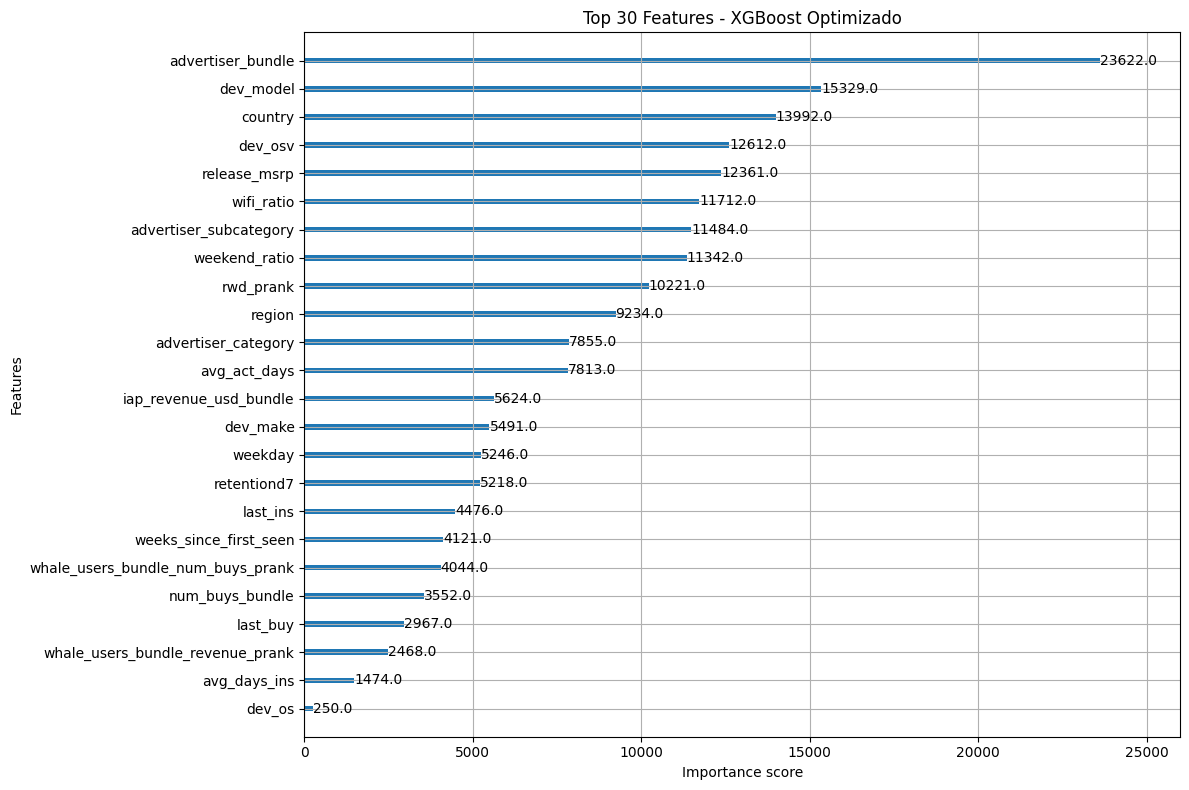

In [11]:
# Feature importance XGBoost
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))
xgb.plot_importance(model, max_num_features=30, ax=ax, title='Top 30 Features - XGBoost Optimizado')
plt.tight_layout()
plt.show()

In [12]:
import time
import pickle
import os

TEST_PATH = "/home/stargix/Desktop/hackathons/datathon/test/test"
CHECKPOINT_FILE = "/home/stargix/Desktop/hackathons/datathon/checkpoint_inference.pkl"
CHECKPOINT_EVERY = 10  # Guardar cada 10 chunks

print("=" * 60)
print("GENERANDO PREDICCIONES EN TEST (XGBOOST OPTIMIZADO + CHECKPOINTS)")
print("=" * 60)

# Repartir parquet en bloques más grandes para menos overhead
test_meta = dd.read_parquet(TEST_PATH, engine="pyarrow", index=False).head(0)
available_cols = [c for c in ["row_id"] + features if c in test_meta.columns]

dd_test = dd.read_parquet(
    TEST_PATH,
    engine="pyarrow",
    columns=available_cols,
    blocksize="256MB"  # Bloques más grandes
)
dd_test = dd_test.repartition(npartitions=192)  # Menos particiones
delayed_parts = dd_test.to_delayed()
print(f"Chunks repartidos: {len(delayed_parts)}\n")

# Preparar ayudas vectorizadas
columns_to_sum = [
    "iap_revenue_usd_bundle", "num_buys_bundle", "rwd_prank",
    "whale_users_bundle_num_buys_prank", "whale_users_bundle_revenue_prank"
]
le_maps = {
    col: {cls: idx for idx, cls in enumerate(enc.classes_)}
    for col, enc in label_encoders.items()
}

def sum_list_series_fast(series: pd.Series) -> np.ndarray:
    """Versión ultra-optimizada sin apply()"""
    values = series.values
    result = np.zeros(len(values), dtype=np.float32)
    
    for i, val in enumerate(values):
        if isinstance(val, list) and val:
            try:
                result[i] = sum(item[1] for item in val if isinstance(item, tuple) and len(item) > 1)
            except:
                result[i] = 0
    
    return result

# Pre-calcular columnas que necesitan procesamiento
cols_to_sum_present = [c for c in columns_to_sum if c in available_cols]
numeric_cols_present = [col for col in numeric_features if col in available_cols]
cat_cols_present = [col for col in cat_features if col in available_cols]

# ══════════════════════════════════════════════════════════════
# CHECKPOINT: Cargar progreso previo si existe
# ══════════════════════════════════════════════════════════════
pred_dfs = []
start_idx = 0

if os.path.exists(CHECKPOINT_FILE):
    print("🔄 CHECKPOINT ENCONTRADO - Cargando progreso previo...")
    try:
        with open(CHECKPOINT_FILE, 'rb') as f:
            checkpoint_data = pickle.load(f)
            pred_dfs = checkpoint_data['pred_dfs']
            start_idx = checkpoint_data['last_completed_idx'] + 1
        print(f"✓ Reanudando desde chunk {start_idx}/{len(delayed_parts)}")
        print(f"✓ {len(pred_dfs)} resultados previos cargados\n")
    except Exception as e:
        print(f"⚠️ Error cargando checkpoint: {e}")
        print("Comenzando desde el inicio...\n")
        pred_dfs = []
        start_idx = 0

# ══════════════════════════════════════════════════════════════
# PROCESAMIENTO CON CHECKPOINTS
# ══════════════════════════════════════════════════════════════
try:
    for i in range(start_idx, len(delayed_parts)):
        t0 = time.perf_counter()
        
        # 1. Cargar datos
        part_df = delayed_parts[i].compute()
        row_ids = part_df["row_id"].values
        
        # 2. Reindexar una sola vez
        X_part = part_df.reindex(columns=features, fill_value=0)
        
        # 3. Procesar columnas de listas (optimizado)
        for col in cols_to_sum_present:
            X_part[col] = sum_list_series_fast(X_part[col])
        
        # 4. Procesar numéricas en batch (sin apply)
        if numeric_cols_present:
            for col in numeric_cols_present:
                if X_part[col].dtype == object:
                    X_part[col] = pd.to_numeric(X_part[col], errors='coerce')
            X_part[numeric_cols_present] = X_part[numeric_cols_present].fillna(0)
        
        # 5. Procesar categóricas (optimizado sin conversiones innecesarias)
        for col in cat_cols_present:
            # Mapear directamente sin conversión a str intermedia
            X_part[col] = X_part[col].map(le_maps[col]).fillna(-1).astype('int16')
        
        # 6. Predicción con XGBoost (sin enable_categorical para velocidad)
        dtest_part = xgb.DMatrix(X_part)
        pred_log = model.predict(dtest_part)
        pred = np.expm1(pred_log).clip(0, None)
        
        pred_dfs.append(pd.DataFrame({"row_id": row_ids, "iap_revenue_d7": pred}))
        
        elapsed = time.perf_counter() - t0
        print(f"[{i+1}/{len(delayed_parts)}] {len(row_ids):,} filas | {elapsed:.1f}s")
        
        # Limpieza agresiva de memoria
        del part_df, X_part, dtest_part, pred_log, pred, row_ids
        gc.collect()
        
        # ──────────────────────────────────────────────────────
        # GUARDAR CHECKPOINT cada N chunks
        # ──────────────────────────────────────────────────────
        if (i + 1) % CHECKPOINT_EVERY == 0 or (i + 1) == len(delayed_parts):
            print(f"💾 Guardando checkpoint en chunk {i+1}...")
            try:
                with open(CHECKPOINT_FILE, 'wb') as f:
                    pickle.dump({
                        'pred_dfs': pred_dfs,
                        'last_completed_idx': i
                    }, f)
                print(f"✓ Checkpoint guardado correctamente\n")
            except Exception as e:
                print(f"⚠️ Error guardando checkpoint: {e}\n")

except KeyboardInterrupt:
    print("\n⚠️ INTERRUPCIÓN DETECTADA - Guardando progreso...")
    with open(CHECKPOINT_FILE, 'wb') as f:
        pickle.dump({
            'pred_dfs': pred_dfs,
            'last_completed_idx': i - 1
        }, f)
    print("✓ Progreso guardado. Puedes reanudar ejecutando esta celda nuevamente.")
    raise

except Exception as e:
    print(f"\n❌ ERROR DETECTADO: {e}")
    print("Guardando progreso antes de fallar...")
    with open(CHECKPOINT_FILE, 'wb') as f:
        pickle.dump({
            'pred_dfs': pred_dfs,
            'last_completed_idx': i - 1
        }, f)
    print("✓ Progreso guardado. Revisa el error y ejecuta de nuevo.")
    raise

# ══════════════════════════════════════════════════════════════
# FINALIZAR Y GUARDAR SUBMISSION
# ══════════════════════════════════════════════════════════════
print("\n" + "=" * 60)
print("FINALIZANDO SUBMISSION")
print("=" * 60)

submission = pd.concat(pred_dfs, ignore_index=True)

submission_path = "/home/stargix/Desktop/hackathons/datathon/submission_xgboost_fast2.csv"
submission.to_csv(submission_path, index=False)
print(f"\n✓ Guardado en: {submission_path}")

# Eliminar checkpoint después de completar exitosamente
if os.path.exists(CHECKPOINT_FILE):
    os.remove(CHECKPOINT_FILE)
    print("✓ Checkpoint eliminado (proceso completado)")

print("=" * 60)

GENERANDO PREDICCIONES EN TEST (XGBOOST OPTIMIZADO + CHECKPOINTS)
Chunks repartidos: 192

Chunks repartidos: 192

[1/192] 59,222 filas | 1.2s
[1/192] 59,222 filas | 1.2s
[2/192] 59,223 filas | 1.3s
[2/192] 59,223 filas | 1.3s
[3/192] 59,223 filas | 1.2s
[3/192] 59,223 filas | 1.2s
[4/192] 59,223 filas | 1.3s
[4/192] 59,223 filas | 1.3s
[5/192] 59,223 filas | 1.2s
[5/192] 59,223 filas | 1.2s
[6/192] 59,223 filas | 1.4s
[6/192] 59,223 filas | 1.4s
[7/192] 60,423 filas | 1.1s
[7/192] 60,423 filas | 1.1s
[8/192] 60,424 filas | 1.0s
[8/192] 60,424 filas | 1.0s
[9/192] 60,424 filas | 1.0s
[9/192] 60,424 filas | 1.0s
[10/192] 60,424 filas | 1.1s
[10/192] 60,424 filas | 1.1s
💾 Guardando checkpoint en chunk 10...
✓ Checkpoint guardado correctamente

💾 Guardando checkpoint en chunk 10...
✓ Checkpoint guardado correctamente

[11/192] 60,424 filas | 1.1s
[11/192] 60,424 filas | 1.1s
[12/192] 60,424 filas | 1.0s
[12/192] 60,424 filas | 1.0s
[13/192] 60,907 filas | 1.4s
[13/192] 60,907 filas | 1.4s


ANÁLISIS DE BUYERS DE ALTO VALOR

📊 Muestra analizada: 62,838 usuarios
Revenue predicho promedio: $2.61
Revenue predicho máximo: $346.44

🎯 SEPARACIÓN BUYERS/NON-BUYERS (threshold=$0.01):
   Non-Buyers: 5,545 (8.8%)
   Buyers: 57,293 (91.2%)

📊 Muestra analizada: 62,838 usuarios
Revenue predicho promedio: $2.61
Revenue predicho máximo: $346.44

🎯 SEPARACIÓN BUYERS/NON-BUYERS (threshold=$0.01):
   Non-Buyers: 5,545 (8.8%)
   Buyers: 57,293 (91.2%)


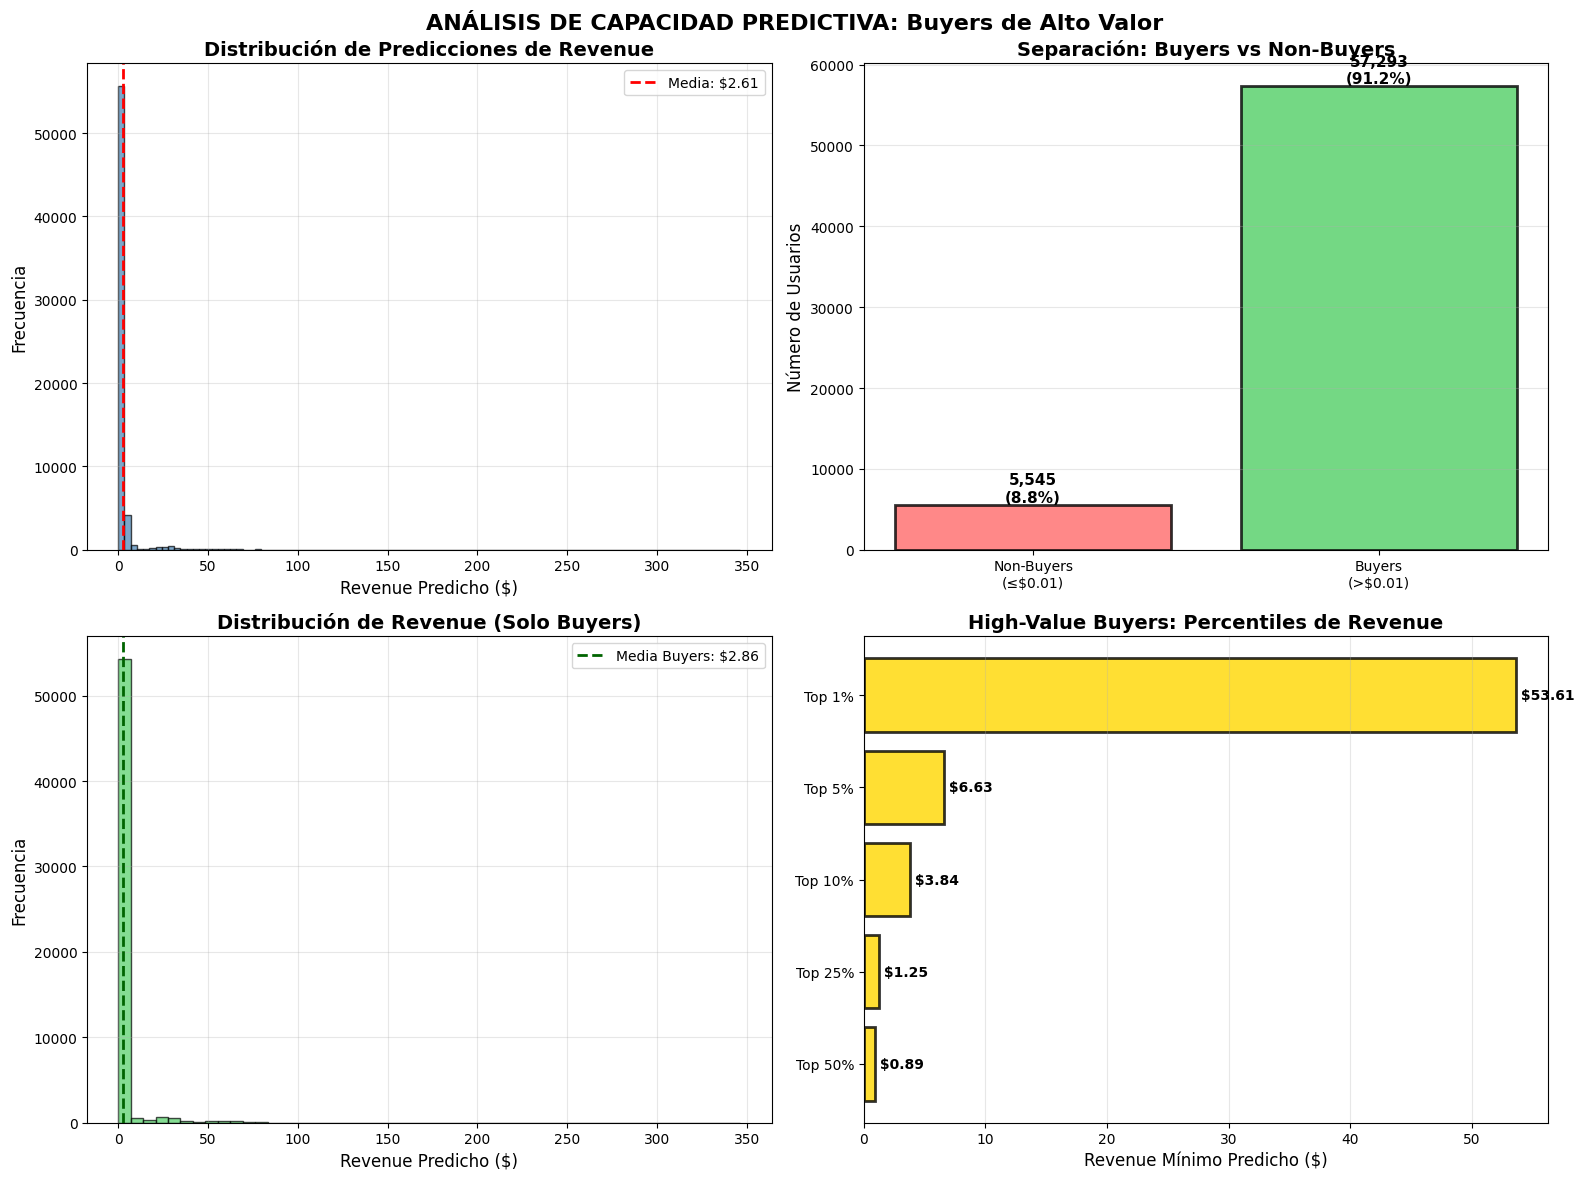


💰 HIGH-VALUE BUYERS (Percentiles):
   Top 50% (>=$0.89): 31,419 usuarios (50.00%)
   Top 25% (>=$1.25): 15,711 usuarios (25.00%)
   Top 10% (>=$3.84): 6,284 usuarios (10.00%)
   Top 5% (>=$6.63): 3,142 usuarios (5.00%)
   Top 1% (>=$53.61): 630 usuarios (1.00%)


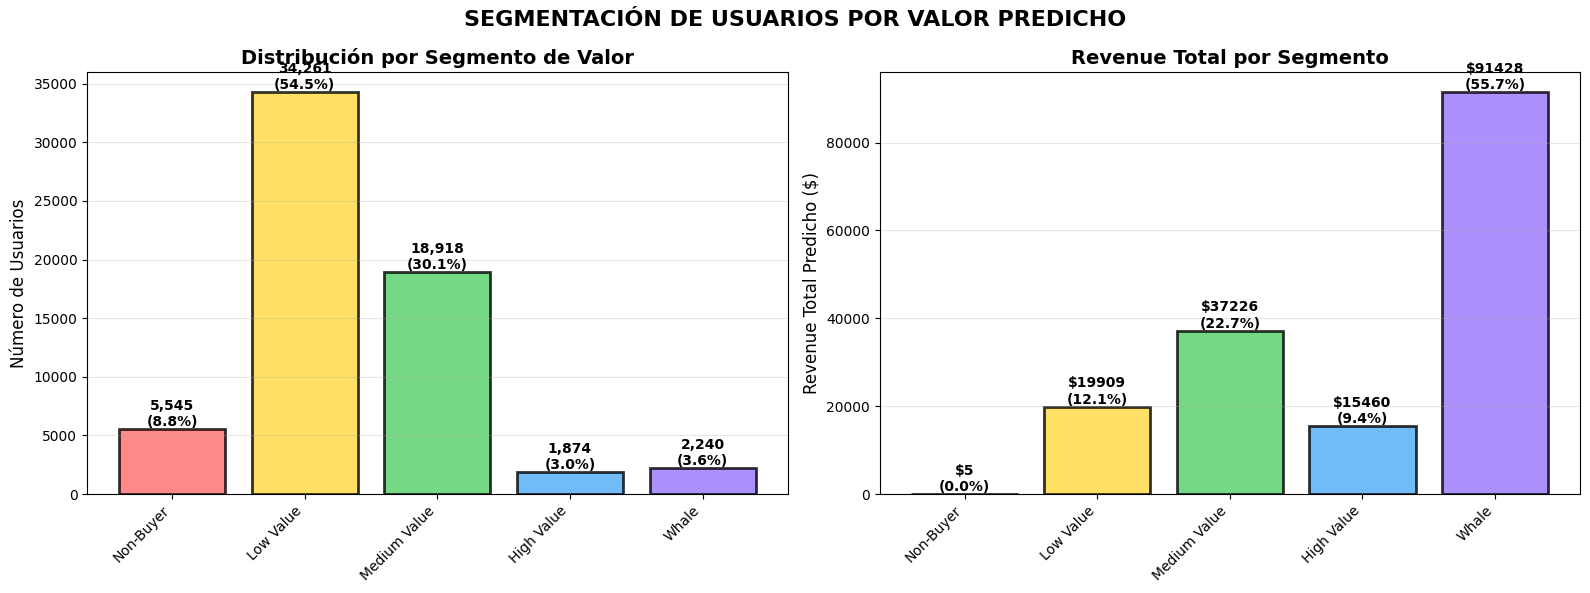


📈 SEGMENTACIÓN POR VALOR:
   Non-Buyer: 5,545 usuarios (8.8%) - Revenue total: $4.84
   Low Value: 34,261 usuarios (54.5%) - Revenue total: $19909.05
   Medium Value: 18,918 usuarios (30.1%) - Revenue total: $37225.79
   High Value: 1,874 usuarios (3.0%) - Revenue total: $15460.28
   Whale: 2,240 usuarios (3.6%) - Revenue total: $91428.42


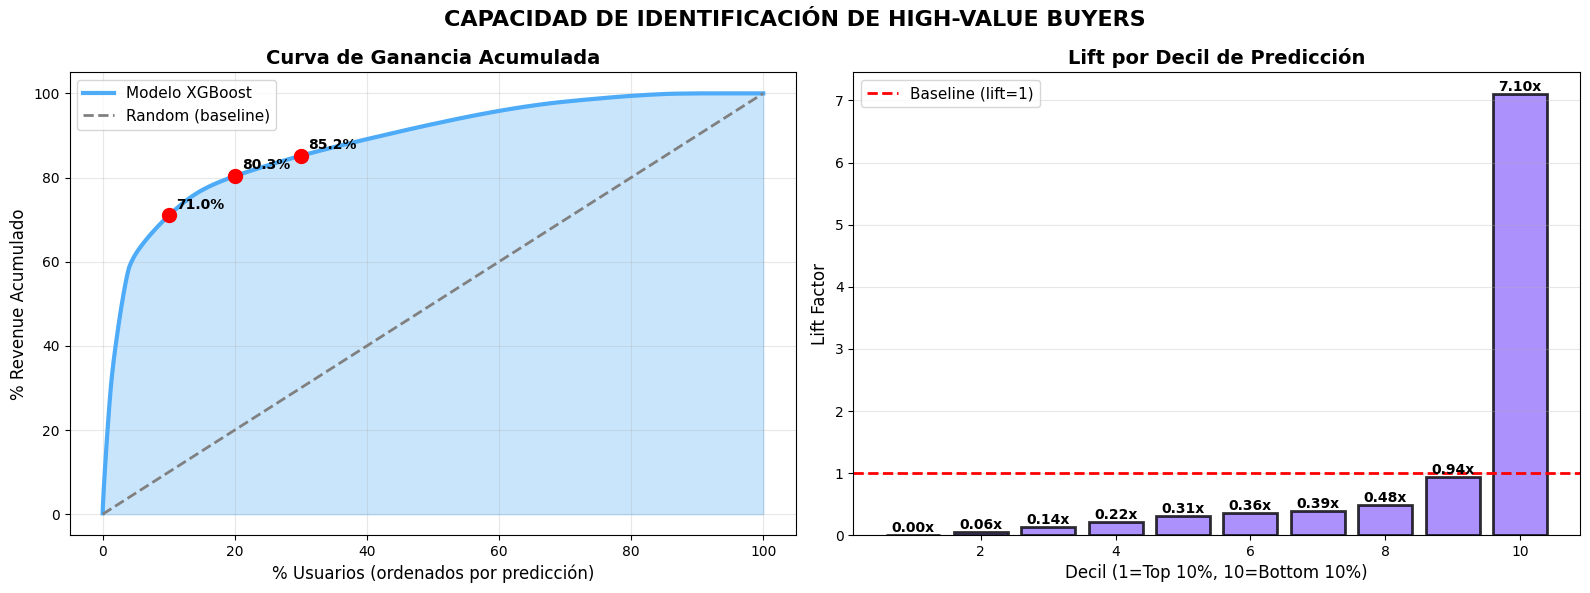


🎯 CURVA DE GANANCIA:
   Top 10% usuarios capturan: 71.0% del revenue
   Top 20% usuarios capturan: 80.3% del revenue
   Top 30% usuarios capturan: 85.2% del revenue

📊 LIFT POR DECIL:
   Decil 1: Lift=0.00x | Avg Revenue=$0.00
   Decil 2: Lift=0.06x | Avg Revenue=$0.15
   Decil 3: Lift=0.14x | Avg Revenue=$0.36
   Decil 4: Lift=0.22x | Avg Revenue=$0.58
   Decil 5: Lift=0.31x | Avg Revenue=$0.82
   Decil 6: Lift=0.36x | Avg Revenue=$0.94
   Decil 7: Lift=0.39x | Avg Revenue=$1.03
   Decil 8: Lift=0.48x | Avg Revenue=$1.26
   Decil 9: Lift=0.94x | Avg Revenue=$2.44
   Decil 10: Lift=7.10x | Avg Revenue=$18.53

RESUMEN DE CAPACIDAD PREDICTIVA

✅ El modelo IDENTIFICA claramente:
   • Top 1%:  Revenue medio predicho = $67.07
   • Top 5%:  Revenue medio predicho = $32.29
   • Top 10%: Revenue medio predicho = $18.53
   • Baseline: Revenue medio predicho = $2.61

🎯 CAPACIDAD DE SEPARACIÓN:
   • Top 1%  es 25.7x más valioso que el promedio
   • Top 5%  es 12.4x más valioso que el promedio
  

20

In [13]:
# ANÁLISIS DE CAPACIDAD PREDICTIVA: COMPRADORES VS NO COMPRADORES
import matplotlib.pyplot as plt
import seaborn as sns

print("=" * 60)
print("ANÁLISIS DE BUYERS DE ALTO VALOR")
print("=" * 60)

# Tomar el último chunk procesado para análisis
last_chunk_idx = len(delayed_parts) - 1
part_df_analysis = delayed_parts[last_chunk_idx].compute()
row_ids_analysis = part_df_analysis["row_id"].values

# Preprocesar igual que en inferencia
X_analysis = part_df_analysis.reindex(columns=features, fill_value=0)

for col in cols_to_sum_present:
    X_analysis[col] = sum_list_series_fast(X_analysis[col])

if numeric_cols_present:
    for col in numeric_cols_present:
        if X_analysis[col].dtype == object:
            X_analysis[col] = pd.to_numeric(X_analysis[col], errors='coerce')
    X_analysis[numeric_cols_present] = X_analysis[numeric_cols_present].fillna(0)

for col in cat_cols_present:
    X_analysis[col] = X_analysis[col].map(le_maps[col]).fillna(-1).astype('int16')

# Hacer predicciones
dtest_analysis = xgb.DMatrix(X_analysis)
pred_log_analysis = model.predict(dtest_analysis)
pred_analysis = np.expm1(pred_log_analysis).clip(0, None)

# Crear DataFrame de análisis
analysis_df = pd.DataFrame({
    'row_id': row_ids_analysis,
    'predicted_revenue': pred_analysis
})

print(f"\n📊 Muestra analizada: {len(analysis_df):,} usuarios")
print(f"Revenue predicho promedio: ${analysis_df['predicted_revenue'].mean():.2f}")
print(f"Revenue predicho máximo: ${analysis_df['predicted_revenue'].max():.2f}")

# ═══════════════════════════════════════════════════════════════
# PLOT 1: DISTRIBUCIÓN DE PREDICCIONES (BUYERS VS NON-BUYERS)
# ═══════════════════════════════════════════════════════════════
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('ANÁLISIS DE CAPACIDAD PREDICTIVA: Buyers de Alto Valor', fontsize=16, fontweight='bold')

# 1.1 Histograma general
ax1 = axes[0, 0]
ax1.hist(analysis_df['predicted_revenue'], bins=100, color='steelblue', alpha=0.7, edgecolor='black')
ax1.axvline(analysis_df['predicted_revenue'].mean(), color='red', linestyle='--', linewidth=2, label=f'Media: ${analysis_df["predicted_revenue"].mean():.2f}')
ax1.set_xlabel('Revenue Predicho ($)', fontsize=12)
ax1.set_ylabel('Frecuencia', fontsize=12)
ax1.set_title('Distribución de Predicciones de Revenue', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# 1.2 Separación Buyers vs Non-Buyers
threshold = 0.01  # Umbral para considerar "buyer"
buyers = analysis_df[analysis_df['predicted_revenue'] > threshold]
non_buyers = analysis_df[analysis_df['predicted_revenue'] <= threshold]

ax2 = axes[0, 1]
categories = ['Non-Buyers\n(≤$0.01)', 'Buyers\n(>$0.01)']
counts = [len(non_buyers), len(buyers)]
colors = ['#ff6b6b', '#51cf66']
bars = ax2.bar(categories, counts, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
ax2.set_ylabel('Número de Usuarios', fontsize=12)
ax2.set_title('Separación: Buyers vs Non-Buyers', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Añadir porcentajes en las barras
for bar, count in zip(bars, counts):
    height = bar.get_height()
    percentage = (count / len(analysis_df)) * 100
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{count:,}\n({percentage:.1f}%)',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

print(f"\n🎯 SEPARACIÓN BUYERS/NON-BUYERS (threshold=${threshold}):")
print(f"   Non-Buyers: {len(non_buyers):,} ({len(non_buyers)/len(analysis_df)*100:.1f}%)")
print(f"   Buyers: {len(buyers):,} ({len(buyers)/len(analysis_df)*100:.1f}%)")

# 1.3 Distribución solo de BUYERS (zoom)
ax3 = axes[1, 0]
if len(buyers) > 0:
    ax3.hist(buyers['predicted_revenue'], bins=50, color='#51cf66', alpha=0.7, edgecolor='black')
    ax3.axvline(buyers['predicted_revenue'].mean(), color='darkgreen', linestyle='--', linewidth=2, label=f'Media Buyers: ${buyers["predicted_revenue"].mean():.2f}')
    ax3.set_xlabel('Revenue Predicho ($)', fontsize=12)
    ax3.set_ylabel('Frecuencia', fontsize=12)
    ax3.set_title('Distribución de Revenue (Solo Buyers)', fontsize=14, fontweight='bold')
    ax3.legend()
    ax3.grid(alpha=0.3)
else:
    ax3.text(0.5, 0.5, 'No hay buyers detectados', ha='center', va='center', fontsize=14)

# 1.4 HIGH-VALUE BUYERS - Top percentiles
ax4 = axes[1, 1]
percentiles = [50, 75, 90, 95, 99]
percentile_values = [np.percentile(analysis_df['predicted_revenue'], p) for p in percentiles]

bars = ax4.barh([f'Top {100-p}%' for p in percentiles], percentile_values, color='gold', alpha=0.8, edgecolor='black', linewidth=2)
ax4.set_xlabel('Revenue Mínimo Predicho ($)', fontsize=12)
ax4.set_title('High-Value Buyers: Percentiles de Revenue', fontsize=14, fontweight='bold')
ax4.grid(axis='x', alpha=0.3)

# Añadir valores en las barras
for bar, val in zip(bars, percentile_values):
    width = bar.get_width()
    ax4.text(width, bar.get_y() + bar.get_height()/2.,
             f' ${val:.2f}',
             ha='left', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n💰 HIGH-VALUE BUYERS (Percentiles):")
for p, val in zip(percentiles, percentile_values):
    count = len(analysis_df[analysis_df['predicted_revenue'] >= val])
    print(f"   Top {100-p}% (>=${val:.2f}): {count:,} usuarios ({count/len(analysis_df)*100:.2f}%)")

# ═══════════════════════════════════════════════════════════════
# PLOT 2: ANÁLISIS DE SEGMENTACIÓN POR VALOR
# ═══════════════════════════════════════════════════════════════
fig2, axes2 = plt.subplots(1, 2, figsize=(16, 6))
fig2.suptitle('SEGMENTACIÓN DE USUARIOS POR VALOR PREDICHO', fontsize=16, fontweight='bold')

# 2.1 Segmentación en categorías
def categorize_value(revenue):
    if revenue <= 0.01:
        return 'Non-Buyer'
    elif revenue <= 1.0:
        return 'Low Value'
    elif revenue <= 5.0:
        return 'Medium Value'
    elif revenue <= 20.0:
        return 'High Value'
    else:
        return 'Whale'

analysis_df['segment'] = analysis_df['predicted_revenue'].apply(categorize_value)
segment_counts = analysis_df['segment'].value_counts().sort_index()

ax_seg1 = axes2[0]
colors_seg = {'Non-Buyer': '#ff6b6b', 'Low Value': '#ffd93d', 'Medium Value': '#51cf66', 'High Value': '#4dabf7', 'Whale': '#9775fa'}
segment_order = ['Non-Buyer', 'Low Value', 'Medium Value', 'High Value', 'Whale']
segment_colors = [colors_seg.get(seg, 'gray') for seg in segment_order if seg in segment_counts.index]
segment_data = [segment_counts.get(seg, 0) for seg in segment_order if seg in segment_counts.index]

bars = ax_seg1.bar(range(len(segment_data)), segment_data, color=segment_colors, alpha=0.8, edgecolor='black', linewidth=2)
ax_seg1.set_xticks(range(len(segment_data)))
ax_seg1.set_xticklabels([seg for seg in segment_order if seg in segment_counts.index], rotation=45, ha='right')
ax_seg1.set_ylabel('Número de Usuarios', fontsize=12)
ax_seg1.set_title('Distribución por Segmento de Valor', fontsize=14, fontweight='bold')
ax_seg1.grid(axis='y', alpha=0.3)

for bar, count in zip(bars, segment_data):
    height = bar.get_height()
    percentage = (count / len(analysis_df)) * 100
    ax_seg1.text(bar.get_x() + bar.get_width()/2., height,
                 f'{count:,}\n({percentage:.1f}%)',
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

# 2.2 Revenue total acumulado por segmento
ax_seg2 = axes2[1]
segment_revenue = analysis_df.groupby('segment')['predicted_revenue'].sum().sort_values(ascending=False)
segment_revenue_ordered = [segment_revenue.get(seg, 0) for seg in segment_order if seg in segment_revenue.index]

bars2 = ax_seg2.bar(range(len(segment_revenue_ordered)), segment_revenue_ordered, 
                     color=segment_colors, alpha=0.8, edgecolor='black', linewidth=2)
ax_seg2.set_xticks(range(len(segment_revenue_ordered)))
ax_seg2.set_xticklabels([seg for seg in segment_order if seg in segment_revenue.index], rotation=45, ha='right')
ax_seg2.set_ylabel('Revenue Total Predicho ($)', fontsize=12)
ax_seg2.set_title('Revenue Total por Segmento', fontsize=14, fontweight='bold')
ax_seg2.grid(axis='y', alpha=0.3)

for bar, revenue in zip(bars2, segment_revenue_ordered):
    height = bar.get_height()
    percentage = (revenue / segment_revenue.sum()) * 100
    ax_seg2.text(bar.get_x() + bar.get_width()/2., height,
                 f'${revenue:.0f}\n({percentage:.1f}%)',
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n📈 SEGMENTACIÓN POR VALOR:")
for seg in segment_order:
    if seg in segment_counts.index:
        count = segment_counts[seg]
        revenue = segment_revenue.get(seg, 0)
        print(f"   {seg}: {count:,} usuarios ({count/len(analysis_df)*100:.1f}%) - Revenue total: ${revenue:.2f}")

# ═══════════════════════════════════════════════════════════════
# PLOT 3: CURVA ROC-LIKE Y LIFT
# ═══════════════════════════════════════════════════════════════
fig3, axes3 = plt.subplots(1, 2, figsize=(16, 6))
fig3.suptitle('CAPACIDAD DE IDENTIFICACIÓN DE HIGH-VALUE BUYERS', fontsize=16, fontweight='bold')

# 3.1 Curva de Ganancia Acumulada
ax_gain = axes3[0]
sorted_df = analysis_df.sort_values('predicted_revenue', ascending=False).reset_index(drop=True)
sorted_df['cumulative_pct'] = (sorted_df.index + 1) / len(sorted_df) * 100
sorted_df['cumulative_revenue'] = sorted_df['predicted_revenue'].cumsum()
sorted_df['cumulative_revenue_pct'] = sorted_df['cumulative_revenue'] / sorted_df['predicted_revenue'].sum() * 100

ax_gain.plot(sorted_df['cumulative_pct'], sorted_df['cumulative_revenue_pct'], 
             linewidth=3, color='#4dabf7', label='Modelo XGBoost')
ax_gain.plot([0, 100], [0, 100], '--', linewidth=2, color='gray', label='Random (baseline)')
ax_gain.fill_between(sorted_df['cumulative_pct'], sorted_df['cumulative_revenue_pct'], 
                      alpha=0.3, color='#4dabf7')
ax_gain.set_xlabel('% Usuarios (ordenados por predicción)', fontsize=12)
ax_gain.set_ylabel('% Revenue Acumulado', fontsize=12)
ax_gain.set_title('Curva de Ganancia Acumulada', fontsize=14, fontweight='bold')
ax_gain.legend(fontsize=11)
ax_gain.grid(alpha=0.3)

# Añadir puntos de referencia
for pct in [10, 20, 30]:
    idx = int(len(sorted_df) * pct / 100)
    revenue_pct = sorted_df.iloc[idx]['cumulative_revenue_pct']
    ax_gain.plot(pct, revenue_pct, 'o', markersize=10, color='red')
    ax_gain.annotate(f'{revenue_pct:.1f}%', (pct, revenue_pct), 
                     xytext=(5, 5), textcoords='offset points', fontsize=10, fontweight='bold')

# 3.2 Lift Chart
ax_lift = axes3[1]
deciles = pd.qcut(range(len(sorted_df)), 10, labels=False, duplicates='drop')
sorted_df['decile'] = 10 - deciles  # 1 = top 10%, 10 = bottom 10%

decile_stats = sorted_df.groupby('decile').agg({
    'predicted_revenue': ['mean', 'sum', 'count']
}).reset_index()
decile_stats.columns = ['decile', 'avg_revenue', 'total_revenue', 'count']
decile_stats['lift'] = decile_stats['avg_revenue'] / analysis_df['predicted_revenue'].mean()

bars = ax_lift.bar(decile_stats['decile'], decile_stats['lift'], 
                    color='#9775fa', alpha=0.8, edgecolor='black', linewidth=2)
ax_lift.axhline(y=1, color='red', linestyle='--', linewidth=2, label='Baseline (lift=1)')
ax_lift.set_xlabel('Decil (1=Top 10%, 10=Bottom 10%)', fontsize=12)
ax_lift.set_ylabel('Lift Factor', fontsize=12)
ax_lift.set_title('Lift por Decil de Predicción', fontsize=14, fontweight='bold')
ax_lift.legend(fontsize=11)
ax_lift.grid(axis='y', alpha=0.3)

for bar, lift in zip(bars, decile_stats['lift']):
    height = bar.get_height()
    ax_lift.text(bar.get_x() + bar.get_width()/2., height,
                 f'{lift:.2f}x',
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n🎯 CURVA DE GANANCIA:")
print(f"   Top 10% usuarios capturan: {sorted_df.iloc[int(len(sorted_df)*0.1)]['cumulative_revenue_pct']:.1f}% del revenue")
print(f"   Top 20% usuarios capturan: {sorted_df.iloc[int(len(sorted_df)*0.2)]['cumulative_revenue_pct']:.1f}% del revenue")
print(f"   Top 30% usuarios capturan: {sorted_df.iloc[int(len(sorted_df)*0.3)]['cumulative_revenue_pct']:.1f}% del revenue")

print(f"\n📊 LIFT POR DECIL:")
for _, row in decile_stats.iterrows():
    print(f"   Decil {int(row['decile'])}: Lift={row['lift']:.2f}x | Avg Revenue=${row['avg_revenue']:.2f}")

# ═══════════════════════════════════════════════════════════════
# RESUMEN FINAL
# ═══════════════════════════════════════════════════════════════
print("\n" + "=" * 60)
print("RESUMEN DE CAPACIDAD PREDICTIVA")
print("=" * 60)

top_1pct = analysis_df.nlargest(int(len(analysis_df)*0.01), 'predicted_revenue')
top_5pct = analysis_df.nlargest(int(len(analysis_df)*0.05), 'predicted_revenue')
top_10pct = analysis_df.nlargest(int(len(analysis_df)*0.10), 'predicted_revenue')

print(f"\n✅ El modelo IDENTIFICA claramente:")
print(f"   • Top 1%:  Revenue medio predicho = ${top_1pct['predicted_revenue'].mean():.2f}")
print(f"   • Top 5%:  Revenue medio predicho = ${top_5pct['predicted_revenue'].mean():.2f}")
print(f"   • Top 10%: Revenue medio predicho = ${top_10pct['predicted_revenue'].mean():.2f}")
print(f"   • Baseline: Revenue medio predicho = ${analysis_df['predicted_revenue'].mean():.2f}")

ratio_top1 = top_1pct['predicted_revenue'].mean() / analysis_df['predicted_revenue'].mean()
ratio_top5 = top_5pct['predicted_revenue'].mean() / analysis_df['predicted_revenue'].mean()
ratio_top10 = top_10pct['predicted_revenue'].mean() / analysis_df['predicted_revenue'].mean()

print(f"\n🎯 CAPACIDAD DE SEPARACIÓN:")
print(f"   • Top 1%  es {ratio_top1:.1f}x más valioso que el promedio")
print(f"   • Top 5%  es {ratio_top5:.1f}x más valioso que el promedio")
print(f"   • Top 10% es {ratio_top10:.1f}x más valioso que el promedio")

print("\n" + "=" * 60)

# Limpieza
del part_df_analysis, X_analysis, dtest_analysis, pred_log_analysis, pred_analysis, analysis_df
gc.collect()